In [4]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [5]:
# Load the data
data = pd.read_csv('h234.csv')

# Drop any rows with missing values
data = data.dropna()

# Separate features (X) and target variable (y)
X = data.drop(columns=['Out_of_Pocket_Cost', 'index'])
y = data['Out_of_Pocket_Cost']

# Split the dataset (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Define models
models = {
    "RandomForest": RandomForestRegressor(random_state=42, n_estimators=100),
    "XGBoost": XGBRegressor(random_state=42, n_estimators=100, objective='reg:squarederror'),
    "LightGBM": LGBMRegressor(random_state=42, n_estimators=100),
}

# Define tolerance for custom accuracy
tolerance = 0.1  # 10% tolerance

# Function to calculate custom accuracy
def custom_accuracy(y_true, y_pred, tolerance):
    return np.mean(np.abs(y_true - y_pred) / y_true < tolerance) * 100

# Initialize dictionary to store results
model_scores = {}

# Evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    custom_acc = custom_accuracy(y_test, y_pred, tolerance)

    model_scores[model_name] = {"RMSE": rmse, "MAE": mae, "Custom Accuracy (10% tolerance)": custom_acc}
    print(f"{model_name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, Custom Accuracy (10% tolerance): {custom_acc:.2f}%")

RandomForest - RMSE: 2327.18, MAE: 902.69, Custom Accuracy (10% tolerance): 5.41%
XGBoost - RMSE: 3066.81, MAE: 959.33, Custom Accuracy (10% tolerance): 3.15%
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1034
[LightGBM] [Info] Number of data points in the train set: 887, number of used features: 45
[LightGBM] [Info] Start training from score 853.390079
LightGBM - RMSE: 1512.28, MAE: 891.02, Custom Accuracy (10% tolerance): 3.60%



Model Performance Comparison:
                      RMSE         MAE  Custom Accuracy (10% tolerance)
RandomForest  2327.176495  902.686126                         5.405405
XGBoost       3066.810952  959.329433                         3.153153
LightGBM      1512.280692  891.024203                         3.603604


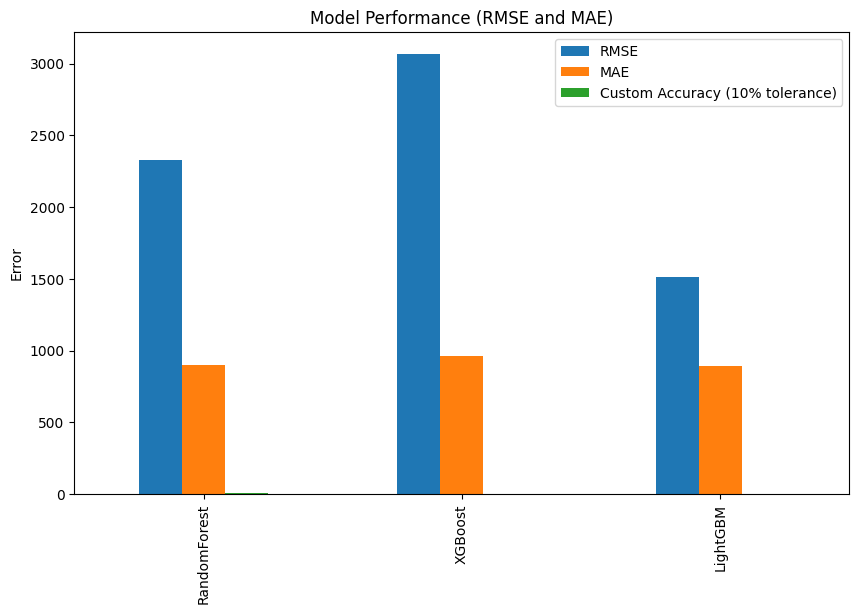

Best model (LightGBM) saved as 'LightGBM_model.pkl'.


In [7]:
# Display model performance comparison
model_performance = pd.DataFrame(model_scores).T
print("\nModel Performance Comparison:\n", model_performance)

# Optional: Plot model performance
model_performance.plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance (RMSE and MAE)")
plt.ylabel("Error")
plt.show()

# Save the best model based on RMSE
best_model_name = model_performance['RMSE'].idxmin()
best_model = models[best_model_name]
pickle.dump(best_model, open(f'{best_model_name}_model.pkl', 'wb'))
print(f"Best model ({best_model_name}) saved as '{best_model_name}_model.pkl'.")

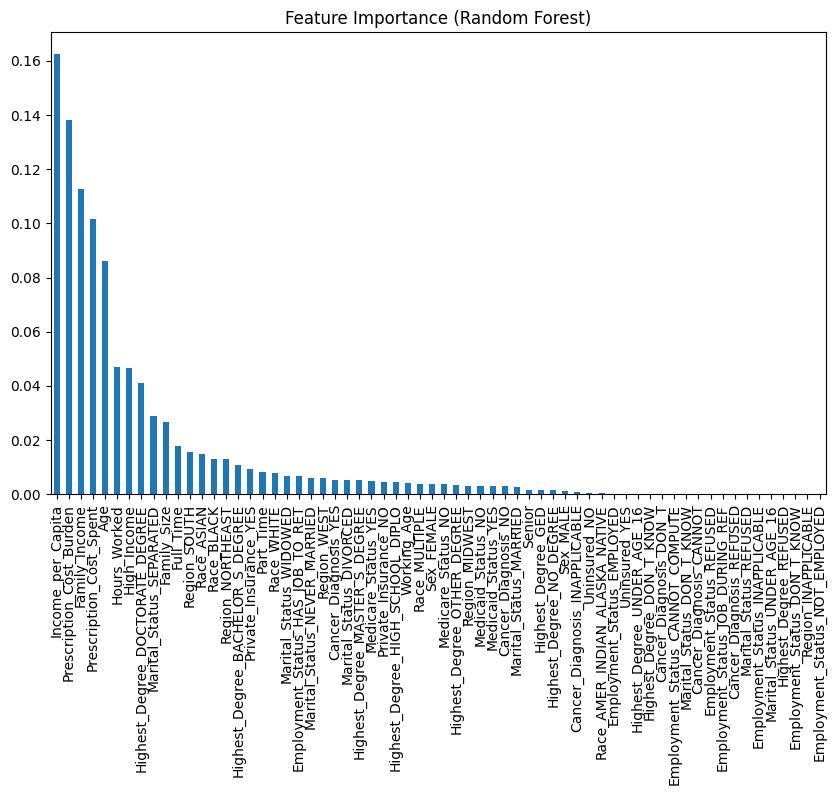

In [8]:
# Check feature importance using Random Forest
feature_importances = models["RandomForest"].feature_importances_
important_features = pd.Series(feature_importances, index=X.columns).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
important_features.plot(kind='bar')
plt.title("Feature Importance (Random Forest)")
plt.show()



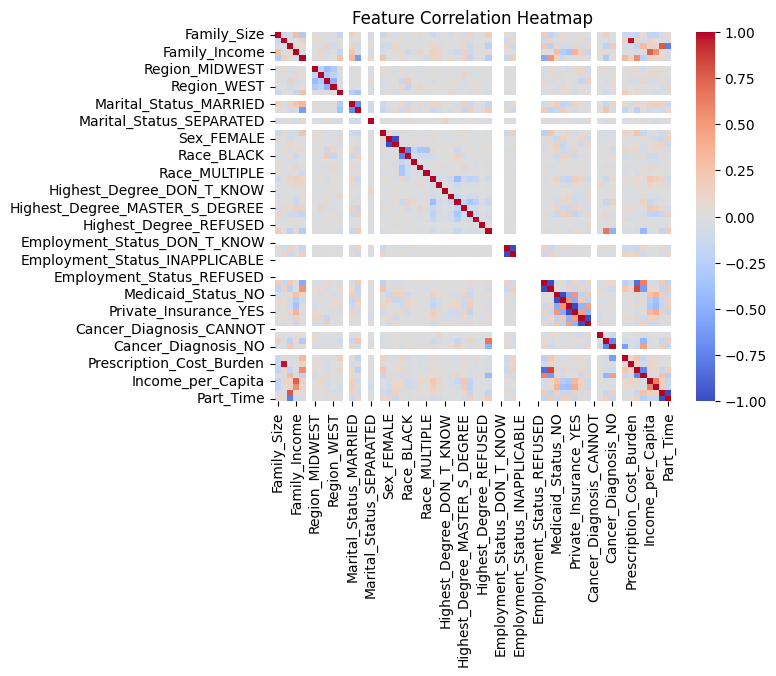

In [9]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor

# Check correlations
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()



In [10]:
X['Income_per_Hour'] = X['Family_Income'] / (X['Hours_Worked'] + 1)  # Avoid division by zero
X['Cost_per_Family'] = X['Prescription_Cost_Spent'] / (X['Family_Size'] + 1)

from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)

# Use X_poly instead of X for training and testing

X['Family_Income_log'] = np.log1p(X['Family_Income'])
X['Prescription_Cost_Spent_log'] = np.log1p(X['Prescription_Cost_Spent'])

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [11]:
from sklearn.model_selection import train_test_split

# Split data into train and test sets *before* applying transformations
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute missing values using SimpleImputer before applying PolynomialFeatures
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean') # You can choose a different strategy if needed

# Fit and transform on training data, then transform test data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Apply PolynomialFeatures (or other transformations) to training and test sets separately
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_imputed)
X_test_poly = poly.transform(X_test_imputed)  # Use transform, not fit_transform, on test data


# Convert the transformed arrays back to DataFrames if needed (for visualization, etc.)
X_train_poly = pd.DataFrame(X_train_poly, columns=poly.get_feature_names_out(X_train.columns), index=X_train.index)
X_test_poly = pd.DataFrame(X_test_poly, columns=poly.get_feature_names_out(X_train.columns), index=X_test.index)

# Ensure all column names are strings (if needed)
X_train_poly.columns = X_train_poly.columns.astype(str)
X_test_poly.columns = X_test_poly.columns.astype(str)


In [12]:
# from sklearn.model_selection import GridSearchCV

# # Parameter grid for Random Forest
# param_grid = {
#     'n_estimators': [100, 300],
#     'max_depth': [10, 20],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2]
# }

# # Initialize and fit GridSearch
# grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5,
#                            scoring='neg_mean_squared_error', n_jobs=-1)
# grid_search.fit(X_train_poly, y_train)

# # Best parameters
# print("Best Parameters for RandomForest:", grid_search.best_params_)

# # Re-evaluate with best model
# best_rf = grid_search.best_estimator_
# y_pred_rf = best_rf.predict(X_test)
# print("Tuned RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

In [18]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

param_grid_lgbm = {
    'n_estimators': [100, 300],      # Fewer boosting rounds to test
    'max_depth': [10, -1],           # Moderate depth and no limit
    'num_leaves': [20, 31],          # Smaller number of leaves
    'learning_rate': [0.01, 0.05],   # Common learning rates
    'subsample': [0.8, 1.0],         # Sample fraction for bagging
    'colsample_bytree': [0.8, 1.0]   # Feature sampling
}

grid_search_lgbm = GridSearchCV(LGBMRegressor(random_state=42), param_grid_lgbm, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_lgbm.fit(X_train, y_train)

print("Best Parameters for LightGBM:", grid_search_lgbm.best_params_)


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1876
[LightGBM] [Info] Number of data points in the train set: 887, number of used features: 49
[LightGBM] [Info] Start training from score 853.390079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best Parameters for LightGBM: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 300, 'num_leaves': 20, 'subsample': 0.8}


In [76]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

best_params = {
    'learning_rate': 0.01,
    'n_estimators': 100,       # Match the GridSearch result
    'num_leaves': 2,
    'min_child_samples': 150,
}

# Initialize LightGBM model with the best parameters
best_lgbm = lgb.LGBMRegressor(**best_params)

# Fit the model to the training data
best_lgbm.fit(X_train_poly, y_train)

# Predict on the test set
y_pred_lgbm = best_lgbm.predict(X_test_poly)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))
print("Tuned RMSE for LightGBM:", rmse)

# Calculate R-squared (R²) for accuracy
r2 = r2_score(y_test, y_pred_lgbm)
print("R-squared for LightGBM:", r2)



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36496
[LightGBM] [Info] Number of data points in the train set: 887, number of used features: 487
[LightGBM] [Info] Start training from score 853.390079
Tuned RMSE for LightGBM: 905.9021384239744
R-squared for LightGBM: 0.014875670767284799
